In [162]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import display

In [163]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [164]:
x = np.linspace(-20,20, 10000)
y = np.sin(x) / x - x / 10

In [165]:
x_y = np.column_stack((x, y))
x_y

array([[-20.        ,   2.04564726],
       [-19.9959996 ,   2.04517435],
       [-19.9919992 ,   2.04470068],
       ...,
       [ 19.9919992 ,  -1.95369916],
       [ 19.9959996 ,  -1.95402557],
       [ 20.        ,  -1.95435274]])

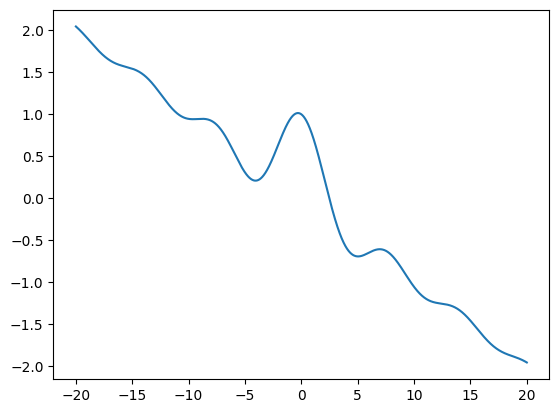

In [166]:
plt.plot(x, y)
plt.show()

## Генратор и Дискриминатор

In [167]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        # метод для построения блоков задач, активацию подтягиваем из словаря выше
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]
            # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает
            # тоже самое что и layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers

        self.model = nn.Sequential(
            # Звездочка означает unpacking списка
            *block(latent_dim, 128, normalize=False),
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
        )

    # при форварде прогоняем данные через модель
    def forward(self, z):
        num = self.model(z)
        return num


class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        # забираем все методы
        super().__init__()
        # инициализируем веса
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        # в PyTorch если объект имеет класс параметров, то он обучаемый,
        # т.е. через него будут прогоняться градиенты
        self.weights = nn.Parameter(weights)

        # подготавливаем переменные для сдвига bias
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # инициализируем веса и смещения (байесы) близкими к нулю значениями
        nn.init.uniform_(self.weights, -0.5, 0.5)
        nn.init.uniform_(self.bias, -0.5, 0.5)

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # на входе размерность, на выходе классфицируем правда/ложь
        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pred):
        validity = self.model(pred)
        # получаем класс ложь/истина
        return validity

In [185]:
n_epochs = 150 # количество эпох
batch_size = 1000 # размер батча
lr = 0.0005  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.99  # гиперпараметр для оптимайзера Adam

latent_dim = 1000  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 100   # количество итераций для отображения процесса обучения

In [186]:
# преобразовываем данные в torch DataLoader
real_data = torch.utils.data.DataLoader(
    x_y,
    batch_size=batch_size,
    shuffle=True)

In [187]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

## Обучение

In [188]:
import matplotlib.patches as mpatches
d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):

        cur_batch_size = len(data)

        # Лейблы для данных: 1 - настоящие, 0 - сгенерированные
        valid = torch.FloatTensor(cur_batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(cur_batch_size, 1).fill_(0.0).to(device)

        # реальные значения перекладываем на устройство
        real_imgs = Variable(data.type(torch.FloatTensor)).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)

#  Тренировка дискриминатора

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_imgs)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()
#  Тренировка генератора    #

        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_imgs.detach())

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


# Отображение процесса обучения и вывод функций потерь #
        batches_done = epoch * len(real_data) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')
                d_loss_history.append(d_loss.cpu().detach().numpy())
                g_loss_history.append(g_loss.cpu().detach().numpy())


[Epoch 0/150] [Batch 0/10]|[D loss: 2.8042855262756348] [G loss: 0.17790690064430237]
[Epoch 10/150] [Batch 0/10]|[D loss: 0.008473386988043785] [G loss: 7.107297897338867]
[Epoch 20/150] [Batch 0/10]|[D loss: 0.0025355848483741283] [G loss: 8.873236656188965]
[Epoch 30/150] [Batch 0/10]|[D loss: 0.0014558261027559638] [G loss: 10.427854537963867]
[Epoch 40/150] [Batch 0/10]|[D loss: 0.0013448880054056644] [G loss: 11.929457664489746]
[Epoch 50/150] [Batch 0/10]|[D loss: 0.0007648641476407647] [G loss: 13.17909049987793]
[Epoch 60/150] [Batch 0/10]|[D loss: 0.0040090493857860565] [G loss: 15.01928997039795]
[Epoch 70/150] [Batch 0/10]|[D loss: 0.0027065551839768887] [G loss: 16.972248077392578]
[Epoch 80/150] [Batch 0/10]|[D loss: 0.0009440964786335826] [G loss: 18.764461517333984]
[Epoch 90/150] [Batch 0/10]|[D loss: 0.00041266385233029723] [G loss: 19.89857292175293]
[Epoch 100/150] [Batch 0/10]|[D loss: 0.00039135030237957835] [G loss: 22.738313674926758]
[Epoch 110/150] [Batch 0/10

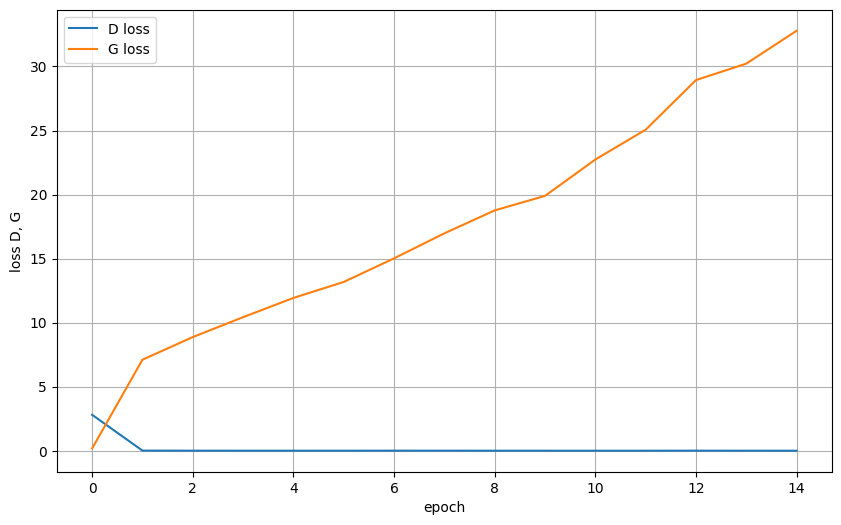

In [190]:
plt.figure(figsize=(10,6))
plt.plot(d_loss_history, label='D loss')
plt.plot(np.array(g_loss_history), label='G loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss D, G')
plt.show()

In [194]:
generator.eval()

# генерируем тестовый тензор
test_z = Variable(torch.from_numpy(np.random.uniform(-40, 35, (100, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

In [192]:
cnt = 0
error = 0.0
count = 0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = (torch.sin(x) / x) - (x / 10).to(device)
   # y_real.to(device)
    y_pred = test_pred[i][1]
    count +=1
    error += abs(y_real - y_pred)

print("Mean error: %.10f" % (error/count))

Mean error: 7.1351189613


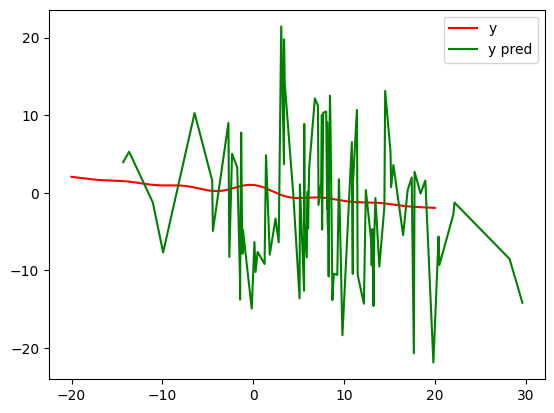

In [193]:
plt.figure()


x = np.linspace(-20, 20, 10000)
plt.plot(x, ((np.sin(x) / x) - (x / 10) ), label='y', color = 'red')

p = test_pred.cpu()[:,0].argsort()
plt.plot(test_pred.cpu()[:,0][p], test_pred.cpu()[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()